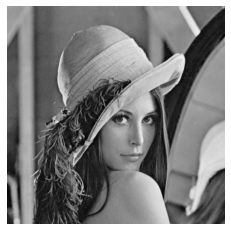

In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import math

img = Image.open('Image/lena.bmp').convert('L')
img = np.array(img)

plt.axis('off')
plt.imshow(img, cmap='gray')

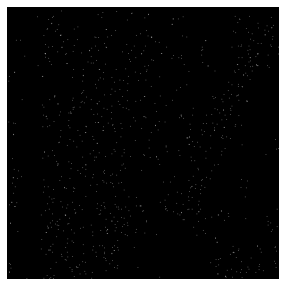

In [2]:
# 1. Design SUSAN/Moravec/Harris corner detector.
def Moravec(img, threshold):
    h,w = img.shape
    CornerMap = np.zeros((h,w))
    img = np.pad(img, ((2,2),(2,2)), 'constant', constant_values=0)
    weight = [[1,1,1],
              [1,1,1],
              [1,1,1]]
    
    for i in range(h): # y
        for j in range(w): #x
            s_array = np.zeros((3,3),dtype='uint8')
            for v in range(-1,2): #y
                for u in range(-1,2): #x
                    # 기준 픽셀 (i+2,j+2), pad 고려           #shift 이후 중앙 픽셀 (i+2+v, j+2+u)
                    d = (img[ i+2-1 :i+2+2, j+2-1: j+2+2 ] - img[ i+2+v-1 : i+2+v+2, j+2+u-1:j+2+u+2])**2
                    d = (d * weight).sum()
                    s_array[v+1,u+1] = d
            CornerMap[i][j] = np.min([s_array[0,1], s_array[1,0],s_array[1,2],s_array[2,1]]) # 상 좌 우 하
    CornerMap[CornerMap>=threshold] = 255
    CornerMap[CornerMap<threshold] = 0
    return CornerMap

MoravecImg = Moravec(img, 190)

plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(MoravecImg, cmap='gray')

In [2]:
def gaussianFilter(size, std):
    filter = np.zeros((size,size))
    filterOffset = size // 2
    for i in range(-filterOffset,filterOffset+1):
        for j in range(-filterOffset,filterOffset+1):
            filter[i+filterOffset][j+filterOffset] = math.exp( -1 * ( i**2 + j**2 ) / (2*(std**2)) )
    return filter / filter.sum()

def filtering(img, filter):   # convolution
    h, w = img.shape
    fSize = len(filter)       # filter Size
    pSize = (fSize-1) // 2    # padding Size
    
    img = np.pad(img, ((pSize,pSize),(pSize,pSize)), 'constant', constant_values=0)
    filteredImg = np.zeros((h,w))
    
    for i in range(pSize,h+pSize):      # operate on ground-truth pixel
        for j in range(pSize,w+pSize):
            product = img[i-pSize:i+pSize+1,j-pSize:j+pSize+1] * filter
            filteredImg[i-pSize][j-pSize] = product.sum()
            
    return filteredImg

In [3]:
def Harris(img, window_size, k, thresh):
    h,w = img.shape
    mx = np.array( [ [-1,0,1],
                   [-2,0,2],
                   [-1,0,1] ])
    my = np.array( [ [-1,-2,-1],
                   [ 0, 0, 0],
                   [ 1, 2, 1] ])
    Ixx = filtering(filtering(img, mx),mx)
    Iyy = filtering(filtering(img, my),my)
    Iyx = filtering(filtering(img, my),mx)
    Ixy = filtering(filtering(img, mx),my)
    
    det = (Ixx * Iyy) - (Ixy*Iyx)
    trace = Ixx + Iyy
    r = det - k*(trace**2)
    newImg = np.zeros((h,w))
    for i in range(h):
        for j in range(w):
            if r[i][j] > thresh:
                newImg[i][j] = 255
    return newImg

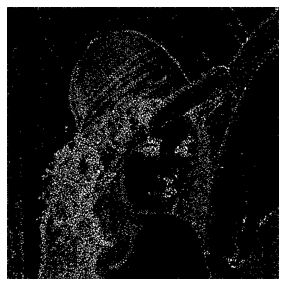

In [4]:
color_img = Harris(img, 3, 0.05, 30000)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(color_img, cmap='gray')

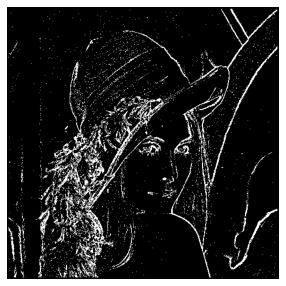

In [11]:
def SUSAN(img, threshold1, threshold2):
    # 7x7
    mask = np.array([[0,0,1,1,1,0,0],
                     [0,1,1,1,1,1,0],
                     [1,1,1,1,1,1,1],
                     [1,1,1,1,1,1,1],
                     [1,1,1,1,1,1,1],
                     [0,1,1,1,1,1,0],
                     [0,0,1,1,1,0,0]])
    h, w = img.shape
    newImg = np.zeros((h,w))
    for i in range(3,h-3):
        for j in range(3, w-3):
            temp = img[i-3:i+4, j-3:j+4].copy()
            temp = mask * temp
            point = img[i,j]
            temp = (abs(temp - point)) <= threshold1
            temp = temp * mask
            usan_area = np.sum(temp)

            if usan_area <=threshold2:
                newImg[i][j] = 255
    return newImg

newImg = SUSAN(img, 5, 5)
plt.figure(figsize=(5,5))
plt.axis('off')
plt.imshow(newImg, cmap='gray')

In [ ]:
def sobelEdgeDetection(img):
    threshold = 150
    mx = [ [-1,0,1],
           [-2,0,2],
           [-1,0,1] ]
    my = [ [-1,-2,-1],
           [ 0, 0, 0],
           [ 1, 2, 1] ]
    
    dx = filtering(img,mx)
    dy = filtering(img,my)
    s = np.sqrt(dx**2 + dy**2)  #strength
    o = np.arctan2(dx, dy)      #orientation
    f = s                       #final
    f[ f>=threshold ] = 255
    f[ f<threshold ] = 0
    return dx, dy, s, o, f

dx,dy,s,o,f1  = sobelEdgeDetection(img)

def morphology(img):
    h,w = img.shape
    newImg  =  img.copy()
    for i in range(1, h-2):
        for j in range(1, w-2):
            if(img[i][j]):
                n0=newImg[i][j+1]  
                n1=newImg[i+1][j+1]
                n2=newImg[i+1][j]
                n3=newImg[i+1][j-1]
                n4=newImg[i][j-1]
                n5=newImg[i-1][j-1]
                n6=newImg[i+1][j]
                n7=newImg[i-1][j+1]
                if((not n0 and (n4 and (n5 or n6 or n2 or n3)and(n6 or not n7)and (n2 or not n1)))or
                   (not n4 and (n0 and (n1 or n2 or n6 or n1)and(n2 or not n3)and (n6 or not n5)))or
                   (not n2 and (n6 and (n7 or n0 or n4 or n5)and(n0 or not n1)and (n4 or not n3)))or
                   (not n6 and (n2 and (n3 or n4 or n0 or n1)and(n4 or not n5)and (n0 or not n7))) ):
                    newImg[i][j] = 0
                    
    return newImg

def morphology2(img):
    h,w = img.shape
    newImg  =  img.copy()
    for i in range(1, h-2):
        for j in range(1, w-2):
            if(img[i][j]):
                n0=newImg[i][j+1]  
                n1=newImg[i+1][j+1]
                n2=newImg[i+1][j]
                n3=newImg[i+1][j-1]
                n4=newImg[i][j-1]
                n5=newImg[i-1][j-1]
                n6=newImg[i+1][j]
                n7=newImg[i-1][j+1]
                if((not n0 and (n4 and (n5 or n6 or n2 or n3)and(n6 or not n7)and (n2 or not n1)))or
                   (not n4 and (n0 and (n1 or n2 or n6 or n1)and(n2 or not n3)and (n6 or not n5)))or
                   (not n2 and (n6 and (n7 or n0 or n4 or n5)and(n0 or not n1)and (n4 or not n3)))or
                   (not n6 and (n2 and (n3 or n4 or n0 or n1)and(n4 or not n5)and (n0 or not n7))) ):
                    newImg[i][j] = 0
                    
    return newImg

f2 = morphology(f1)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(f1, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(f2, cmap='gray')

In [12]:
# 3. Design a part of SIFT method

def scaling(img, k):  
    h, w = img.shape
    nh = round(h*k)
    nw = round(w*k)
    scaledImg = np.zeros((nh, nw))
    img = np.pad(img, ((0,1),(0,1)), 'symmetric')
    for i in range(nh):     # y
        for j in range(nw): # x
            y = i / k
            x = j / k
            x1, y1 = math.floor(x), math.floor(y)
            x2, y2 = x1 + 1, y1 + 1
            a = x-x1
            b = y-y1
            
            value = (1-a) * ( (1-b)*img[y1,x1] + b*img[y2, x1] ) \
                                + a * ((1-b) * img[y1,x2]  + b*img[y2, x2])
            scaledImg[i][j] = value
    return scaledImg

def SIFT(img, octave=2, scale=0.8, sigma = 1):
    paramid = list()
    for i in range(octave):
        imgList = list()
        for j in range(6):
            imgList.append(img)
            img = filtering(img, gaussianFilter(3,sigma+j))
        paramid.append(imgList)
        img = scaling(img,scale)
    paramid = np.array(paramid)
    
    difference = list()
    for i in range(octave):
        tempList = list()
        for j in range(5):
            tempList.append(paramid[i][j+1]-paramid[i][j])
        difference.append(tempList)
    difference = np.array(difference)    
    return paramid, difference

img = Image.open('Image/lena.bmp').convert('L')
img = np.array(img)
paramid, difference= SIFT(img)
                    


c:\users\jaehyeon\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
c:\users\jaehyeon\anaconda\envs\pytorch\lib\site-packages\ipykernel_launcher.py:40: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


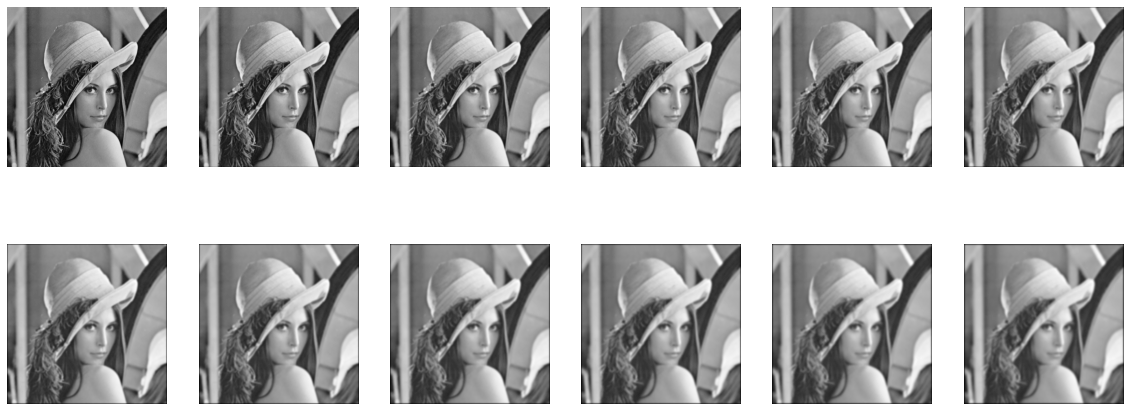

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(2,6,1)
plt.axis('off')
plt.imshow(paramid[0][0], cmap='gray')
plt.subplot(2,6,2)
plt.axis('off')
plt.imshow(paramid[0][1], cmap='gray')
plt.subplot(2,6,3)
plt.axis('off')
plt.imshow(paramid[0][2], cmap='gray')
plt.subplot(2,6,4)
plt.axis('off')
plt.imshow(paramid[0][3], cmap='gray')
plt.subplot(2,6,5)
plt.axis('off')
plt.imshow(paramid[0][4], cmap='gray')
plt.subplot(2,6,6)
plt.axis('off')
plt.imshow(paramid[0][5], cmap='gray')
plt.subplot(2,6,7)
plt.axis('off')
plt.imshow(paramid[1][0], cmap='gray')
plt.subplot(2,6,8)
plt.axis('off')
plt.imshow(paramid[1][1], cmap='gray')
plt.subplot(2,6,9)
plt.axis('off')
plt.imshow(paramid[1][2], cmap='gray')
plt.subplot(2,6,10)
plt.axis('off')
plt.imshow(paramid[1][3], cmap='gray')
plt.subplot(2,6,11)
plt.axis('off')
plt.imshow(paramid[1][4], cmap='gray')
plt.subplot(2,6,12)
plt.axis('off')
plt.imshow(paramid[1][5], cmap='gray')

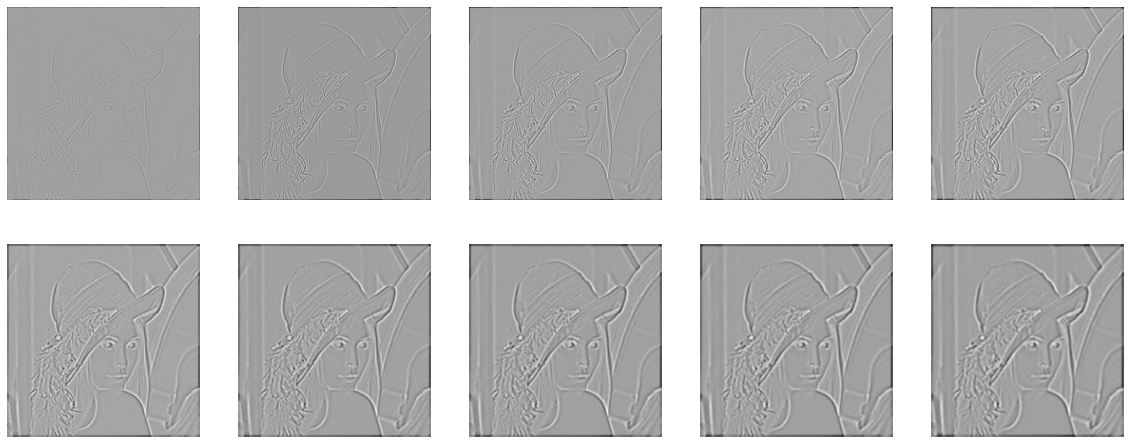

In [14]:
plt.figure(figsize=(20,8))
plt.subplot(2,5,1)
plt.axis('off')
plt.imshow(difference[0][0], cmap='gray')
plt.subplot(2,5,2)
plt.axis('off')
plt.imshow(difference[0][1], cmap='gray')
plt.subplot(2,5,3)
plt.axis('off')
plt.imshow(difference[0][2], cmap='gray')
plt.subplot(2,5,4)
plt.axis('off')
plt.imshow(difference[0][3], cmap='gray')
plt.subplot(2,5,5)
plt.axis('off')
plt.imshow(difference[0][4], cmap='gray')
plt.subplot(2,5,6)
plt.axis('off')
plt.imshow(difference[1][0], cmap='gray')
plt.subplot(2,5,7)
plt.axis('off')
plt.imshow(difference[1][1], cmap='gray')
plt.subplot(2,5,8)
plt.axis('off')
plt.imshow(difference[1][2], cmap='gray')
plt.subplot(2,5,9)
plt.axis('off')
plt.imshow(difference[1][3], cmap='gray')
plt.subplot(2,5,10)
plt.axis('off')
plt.imshow(difference[1][4], cmap='gray')